<a href="https://colab.research.google.com/github/dkeitley/dev-neuro-brainspan/blob/master/dev_neuro_with_brainspan.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Develpmental Neurobiology with BrainSpan

## Package Installation

In [1]:
!pip install allensdk

## Helper Functions

In [0]:
from allensdk.api.queries.image_download_api import ImageDownloadApi
from allensdk.api.queries.svg_api import SvgApi
from allensdk.api.queries.grid_data_api import GridDataApi
from allensdk.config.manifest import Manifest

import matplotlib.pyplot as plt
from skimage.io import imread
import pandas as pd
import urllib.request, json 
from pandas.io.json import json_normalize
import xml.etree.ElementTree as ET
import numpy as np


import logging
import os
from base64 import b64encode

from IPython.display import HTML, display

#plt.rcParams['figure.dpi']= 300


In [0]:
def verify_image(file_path, figsize=(9, 11),title=""):
    image = imread(file_path)

    fig, ax = plt.subplots(figsize=figsize)
    ax.imshow(image)
    ax.set_title(title)
    
    
def verify_svg(file_path, width_scale, height_scale):
    # we're using this function to display scaled svg in the rendered notebook.
    # we suggest that in your own work you use a tool such as inkscape or illustrator to view svg
    
    with open(file_path, 'rb') as svg_file:
        svg = svg_file.read()
    encoded_svg = b64encode(svg)
    decoded_svg = encoded_svg.decode('ascii')
    
    st = r'<img class="figure" src="data:image/svg+xml;base64,{}" width={}% height={}%></img>'.format(decoded_svg, width_scale, height_scale)
    display(HTML(st))
    
def find_section(df,section_num):
  mid_section = df.iloc[(df['section_number']-section_num).abs().argsort()][:1]
  return mid_section['id'].item()


In [0]:
image_api = ImageDownloadApi()
svg_api = SvgApi()


In [0]:
def get_micro_array_expression(url,exp_type):
  with urllib.request.urlopen(url) as response:
    data = json.loads(response.read())
    donors = json_normalize(data['msg']['samples'])
    exps = []
    
    # if multiple probes, just take the first
    # TODO choose probe with highest intensity, assuming z-scores are similar
    if (len(data['msg']['probes']) > 1):
      exps = json_normalize(data['msg']['probes'][0],exp_type,['gene-symbol','id','gene-name','gene-id'])
    else:
      exps = json_normalize(data['msg']['probes'],exp_type,['gene-symbol','id','gene-name','gene-id'])
      
    exps.rename(columns = {0:exp_type}, inplace = True)
    exps[[exp_type]] = exps[[exp_type]].apply(pd.to_numeric)
    data = pd.concat([exps,donors],1)
    
  return data



def get_rna_seq_expression(url):
  with urllib.request.urlopen(url) as response:
    data = json.loads(response.read())
    donors = json_normalize(data['msg']['samples'])
    exps = []
    
    exps = json_normalize(data['msg']['probes'],'expression_level',['gene-symbol','id','gene-name','gene-id'])
      
    exps.rename(columns = {0:'expression_level'}, inplace = True)
    exps[["expression_level"]] = exps[["expression_level"]].apply(pd.to_numeric)
    data = pd.concat([exps,donors],1)
    
  return data
  
  
def get_gene_id(url):
  id = 0
  with urllib.request.urlopen(url) as response:
    xml = ET.fromstring(response.read()) 
    id_str = xml[0][0][0].text
  return id_str


def get_probe_ids(url):
  # adds multiple probes to expression search
  id_str = ""
  with urllib.request.urlopen(url) as response:
    xml = ET.fromstring(response.read()) 
    i = 0 
    for probe in xml[0].findall('probe'):
      if(i==0):
        id_str = probe[0].text
      else:
        id_str = id_str + "," + probe[0].text
      i+=1
  return id_str




In [0]:
def get_expression_data(gene,seq_type):
  ''' e.g. get_expression_data("EOMES","rna-seq")
  '''
  
  if(seq_type=="rna-seq"):
    # Find Gene ID
    gene_id_url_1 = "http://api.brain-map.org/api/v2/data/query.xml?criteria=model::Gene,%20rma::criteria,[acronym$eq%27"
    gene_id_url_2 = "%27][type$eq%27EnsemblGene%27],organism[name$eq%27Homo%20Sapiens%27],%20rma::options[only$eq%27genes.id%27]"
    gene_id_url = gene_id_url_1 + gene + gene_id_url_2

    id_str = get_gene_id(gene_id_url)

    # Get expression levels   
    exp_url = "http://api.brain-map.org/api/v2/data/query.json?criteria=service::dev_human_expression[set$eq%27rna_seq_genes%27][probes$eq"
    exp_url = exp_url + id_str + "]"
    print(exp_url)
    data = get_gene_expression(exp_url)
    
  elif(seq_type=="microarray"):
    probe_id_url = "http://api.brain-map.org/api/v2/data/query.xml?criteria=model::Probe,rma::criteria,[probe_type$eq%27DNA%27],gene[acronym$eq%27"
    probe_id_url = probe_id_url + gene + "%27],rma::options[only$eq%27probes.id%27]"
    id_str = get_probe_ids(probe_id_url)
    
    exp_url = "http://api.brain-map.org/api/v2/data/query.json?criteria=service::dev_human_microarray_expression[probes$eq" + id_str + "]"
    data = get_micro_array_expression(exp_url,'z-score')

  return data

## Reference Atlases

In [0]:
# TOOO: work out how to improve resolution. 

pcw15_atlas_id = 138322603
pcw21_atlas_id = 3
yr34_atlas_id = 138322605

pcw15_atlas_records = image_api.atlas_image_query(pcw15_atlas_id)
pcw21_atlas_records = image_api.atlas_image_query(pcw21_atlas_id)
yr34_atlas_records = image_api.atlas_image_query(yr34_atlas_id)

pcw15_atlas_section_id = find_section(pd.DataFrame(pcw15_atlas_records),600)
pcw21_atlas_section_id = find_section(pd.DataFrame(pcw21_atlas_records),1500)
yr34_atlas_section_id = find_section(pd.DataFrame(yr34_atlas_records),1400)



2018-12-11 12:18:56,858 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/atlas_image_download/102125559?downsample=4&annotation=true
2018-12-11 12:18:57,369 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/atlas_image_download/101892607?downsample=4&annotation=true
2018-12-11 12:18:58,162 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/atlas_image_download/112282839?downsample=4&annotation=true


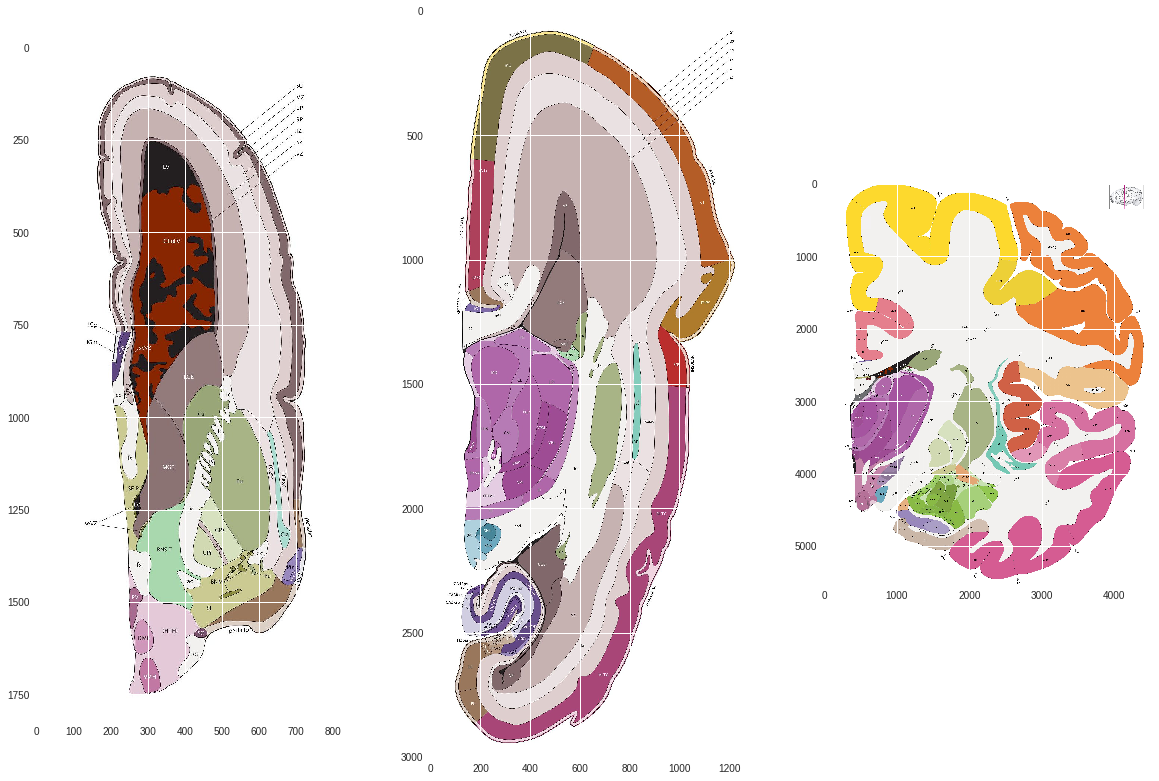

In [8]:
file_path = 'annotation.jpg'
image_api.download_atlas_image(pcw15_atlas_section_id, "15pcw_atlas.jpg", annotation=True, downsample=4)
image_api.download_atlas_image(pcw21_atlas_section_id, "21pcw_atlas.jpg", annotation=True, downsample=4)
image_api.download_atlas_image(yr34_atlas_section_id, "34yr_atlas.jpg", annotation=True, downsample=4)

fig, ax = plt.subplots(ncols=3, figsize=(20, 44))
pcw15_image = imread("15pcw_atlas.jpg")
pcw21_image = imread("21pcw_atlas.jpg")
yr34_image = imread("34yr_atlas.jpg")

ax[0].imshow(pcw15_image)
ax[1].imshow(pcw21_image)
ax[2].imshow(yr34_image)


# AP Patterning

# Neurogenesis

In [0]:
def download_section(section_id,section_image_directory):
  section_images = image_api.section_image_query(section_id)
  section_image_ids = [si['id'] for si in section_images]

  logging.getLogger('allensdk.api.api.retrieve_file_over_http').disabled = True

  for section_image_id in section_image_ids:

      file_name = str(section_image_id) + format_str
      file_path = os.path.join(section_image_directory, file_name)

      Manifest.safe_make_parent_dirs(file_path)
      image_api.download_section_image(section_image_id, file_path=file_path, downsample=downsample)

  logging.getLogger('allensdk.api.api.retrieve_file_over_http').disabled = False

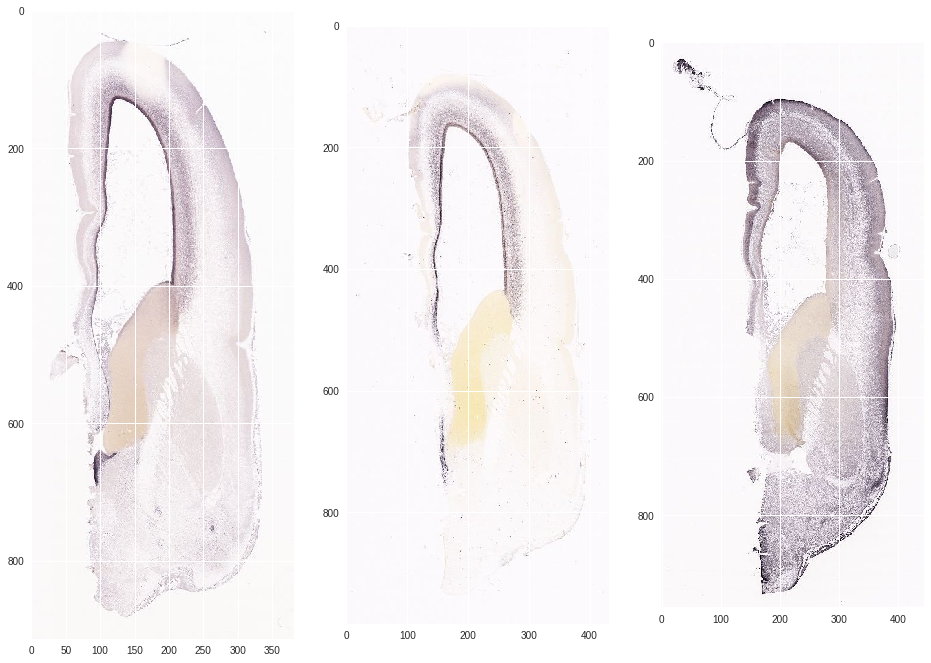

In [19]:
# TODO: Add if statement to prevent downloading dataset if already downloaded

pax6_section_id = 100143447
#pax6_image_id = 102187868

tbr2_section_id = 100142338
#tbr2_image_id = 102166887

tbr1_section_id = 100142262


downsample = 5
format_str = '.jpg'

pax6_records = image_api.section_image_query(pax6_section_id)
tbr2_records = image_api.section_image_query(tbr2_section_id)
tbr1_records = image_api.section_image_query(tbr1_section_id)

pax6_image_id = find_section(pd.DataFrame(pax6_records),600)
tbr2_image_id = find_section(pd.DataFrame(tbr2_records),600)
tbr1_image_id = find_section(pd.DataFrame(tbr1_records),600)

download_section(pax6_section_id,"pax6")
download_section(tbr2_section_id,"tbr2")
download_section(tbr1_section_id,"tbr1")

pax6_file_path = os.path.join("pax6",str(pax6_image_id) + format_str)
tbr2_file_path = os.path.join("tbr2",str(tbr2_image_id) + format_str)
tbr1_file_path = os.path.join("tbr1",str(tbr1_image_id) + format_str)

fig, ax = plt.subplots(ncols=3, figsize=(16, 16))
pax6_image = imread(pax6_file_path)
tbr2_image = imread(tbr2_file_path)
tbr1_image = imread(tbr1_file_path)

ax[0].imshow(pax6_image)
ax[1].imshow(tbr2_image)
ax[2].imshow(tbr1_image)



Text(0.5,1,'Pax6/TBR2/TBR1 expression in CP')

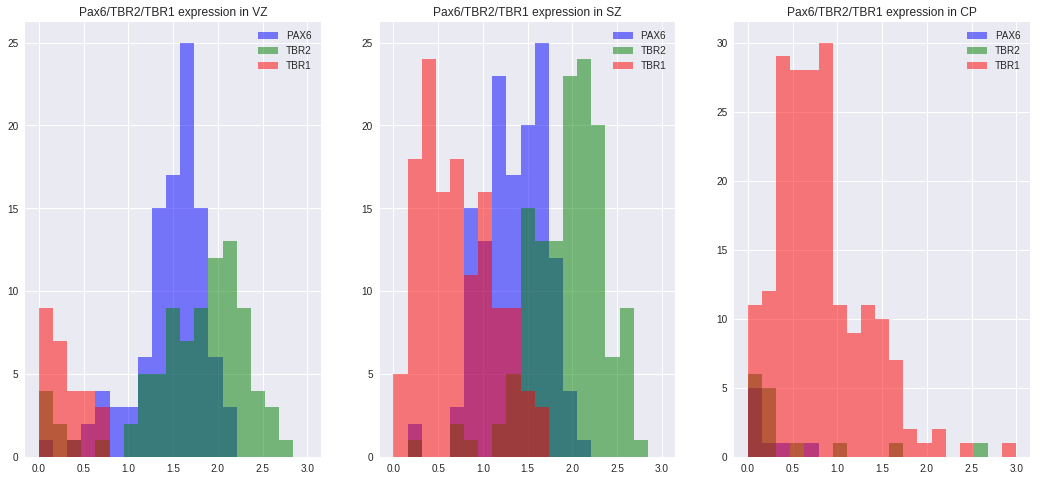

In [13]:

pax6_exp = get_expression_data("PAX6","microarray")
tbr2_exp = get_expression_data("EOMES","microarray")
tbr1_exp = get_expression_data("TBR1","microarray")


vz_pax6 = pax6_exp[pax6_exp['top_level_structure.abbreviation'] == 'VZ']
vz_tbr2 = tbr2_exp[tbr2_exp['top_level_structure.abbreviation'] == 'VZ']
vz_tbr1 = tbr1_exp[tbr1_exp['top_level_structure.abbreviation'] == 'VZ']

sz_pax6 = pax6_exp[pax6_exp['top_level_structure.abbreviation'] == 'SZ']
sz_tbr2 = tbr2_exp[tbr2_exp['top_level_structure.abbreviation'] == 'SZ']
sz_tbr1 = tbr1_exp[tbr1_exp['top_level_structure.abbreviation'] == 'SZ']

cp_tbr1 = tbr1_exp[tbr1_exp['top_level_structure.abbreviation'] == 'CP']
cp_tbr2 = tbr2_exp[tbr2_exp['top_level_structure.abbreviation'] == 'CP']
cp_pax6 = pax6_exp[pax6_exp['top_level_structure.abbreviation'] == 'CP']


bins = np.linspace(0, 3, 20)

fig, ax = plt.subplots(ncols=3, figsize=(18, 8))

ax[0].hist(vz_pax6['z-score'],bins,alpha=0.5,label='PAX6',color='b')
ax[0].hist(vz_tbr2['z-score'],bins,alpha=0.5,label='TBR2',color='g')
ax[0].hist(vz_tbr1['z-score'],bins,alpha=0.5,label='TBR1',color='r')
ax[0].legend(loc='upper right')
ax[0].set_title("Pax6/TBR2/TBR1 expression in VZ")

ax[1].hist(sz_pax6['z-score'],bins,alpha=0.5,label='PAX6',color='b')
ax[1].hist(sz_tbr2['z-score'],bins,alpha=0.5,label='TBR2',color='g')
ax[1].hist(sz_tbr1['z-score'],bins,alpha=0.5,label='TBR1',color='r')
ax[1].legend(loc='upper right')
ax[1].set_title("Pax6/TBR2/TBR1 expression in SZ")

ax[2].hist(cp_pax6['z-score'],bins,alpha=0.5,label='PAX6',color='b')
ax[2].hist(cp_tbr2['z-score'],bins,alpha=0.5,label='TBR2',color='g')
ax[2].hist(cp_tbr1['z-score'],bins,alpha=0.5,label='TBR1',color='r')
ax[2].legend(loc='upper right')
ax[2].set_title("Pax6/TBR2/TBR1 expression in CP")





# Cortical Arealisation